# [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [107]:
# Copied code to load in the data
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)
        

import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [111]:
# Values range from 0 to 255
x_train[0:3,125:135]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.19921875, 0.62109375, 0.98828125,
        0.62109375, 0.1953125 , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)

(50000, 784)

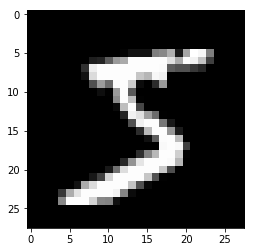

In [112]:
# Show an image
plt.imshow(x_train[0].reshape(28, 28), cmap='gray')
x_train.shape

## PyTorch

In [158]:
import torch

# Convert NumPy arrays to torch tensors
trn_X, trn_y, tst_X, tst_y = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

# trn_X = trn_X.type('torch.FloatTensor')
# trn_y = trn_y.type('torch.FloatTensor')
# tst_X = tst_X.type('torch.FloatTensor')
# tst_y = tst_y.type('torch.FloatTensor')

In [162]:
type(trn_X)

torch.Tensor

### Create a neural network from scratch

In [163]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
# trailing _'s in PyTorch signifies an in-place operation
weights.requires_grad_()
# bias: kind of like a coefficient added to each term
bias = torch.zeros(10, requires_grad=True)
weights

tensor([[-0.0332,  0.0048, -0.0641,  ..., -0.0322,  0.0235,  0.0428],
        [ 0.0143, -0.0094,  0.0057,  ...,  0.0432,  0.0010,  0.0522],
        [ 0.0291,  0.0356,  0.0768,  ...,  0.0067, -0.0169,  0.0313],
        ...,
        [ 0.0210,  0.0206,  0.0487,  ..., -0.0180,  0.0284, -0.0210],
        [ 0.0946, -0.0036,  0.0168,  ...,  0.0292,  0.0389, -0.0318],
        [ 0.0014,  0.0417, -0.0762,  ..., -0.0224,  0.0257, -0.0012]],
       requires_grad=True)

In [164]:
# Activation function
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

log_softmax(torch.tensor([0.0, 1.0]))

tensor([-1.3133, -0.3133])

In [165]:
# Example to understand log_softmax
test_tensor = torch.tensor([[1., 2, 3], [4, 5, 6]])
print(test_tensor.shape)
print(test_tensor.exp())
print(test_tensor.exp().sum(-1))
print(test_tensor.exp().sum(-1).log())
print(test_tensor.exp().sum(-1).unsqueeze(-1))
print(test_tensor - test_tensor.exp().sum(-1).unsqueeze(-1))

torch.Size([2, 3])
tensor([[  2.7183,   7.3891,  20.0855],
        [ 54.5982, 148.4132, 403.4288]])
tensor([ 30.1929, 606.4401])
tensor([3.4076, 6.4076])
tensor([[ 30.1929],
        [606.4401]])
tensor([[ -29.1929,  -28.1929,  -27.1929],
        [-602.4401, -601.4401, -600.4401]])


In [166]:
# Model for learning
def model(batch):
    return log_softmax(batch @ weights + bias)
# Note: @ is the dot product operation

In [167]:
# Check to make sure dimensions line up
trn_X.shape, weights.shape, bias.shape

(torch.Size([50000, 784]), torch.Size([784, 10]), torch.Size([10]))

In [168]:
batch_size = 64

batch = trn_X[0:batch_size]
predictions = model(batch)
predictions[0], predictions.shape

(tensor([-2.5336, -1.9068, -2.4705, -2.3072, -2.8452, -2.5241, -2.0376, -2.6237,
         -1.8578, -2.3987], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [169]:
# Loss function: the higher, the worse the model performs
def neg_log_likelihood(predictions, target):
    return -predictions[range(target.shape[0]), target].mean()

loss_function = neg_log_likelihood

In [170]:
print(predictions.shape, trn_y[0:batch_size].shape)
loss_function(predictions, trn_y[0:batch_size])

torch.Size([64, 10]) torch.Size([64])


tensor(2.3128, grad_fn=<NegBackward>)

In [171]:
# Accuracy function
def accuracy(predictions, target):
    preds = torch.argmax(predictions, dim=1)
    return (preds == target).float().mean()

In [172]:
accuracy(predictions, trn_y[0:batch_size])

tensor(0.1406)

#### Training the model

In [173]:
# Train
learning_rate = 0.5
epochs = 2

for epoch in range(epochs):
    # Run through all the data in batches
    for i in range((trn_X.shape[0] - 1) // batch_size + 1):
        start = i * batch_size
        end = start + batch_size
        batch_X = trn_X[start:end]
        batch_y = trn_y[start:end]
        predictions = model(batch_X)
        model_loss = loss_function(predictions, batch_y)

        # Calculate gradients on weights and bias
        model_loss.backward()
        # Update weights and bias, but don't calculate gradients for this process
        with torch.no_grad():
            weights -= weights.grad * learning_rate
            bias -= bias.grad * learning_rate
            # Set gradients to zero so gradients are correct for next loop
            weights.grad.zero_()
            bias.grad.zero_()

In [174]:
weights, bias

(tensor([[-0.0332,  0.0048, -0.0641,  ..., -0.0322,  0.0235,  0.0428],
         [ 0.0143, -0.0094,  0.0057,  ...,  0.0432,  0.0010,  0.0522],
         [ 0.0291,  0.0356,  0.0768,  ...,  0.0067, -0.0169,  0.0313],
         ...,
         [ 0.0210,  0.0206,  0.0487,  ..., -0.0180,  0.0284, -0.0210],
         [ 0.0946, -0.0036,  0.0168,  ...,  0.0292,  0.0389, -0.0318],
         [ 0.0014,  0.0417, -0.0762,  ..., -0.0224,  0.0257, -0.0012]],
        requires_grad=True),
 tensor([-0.4629,  0.4014,  0.1777, -0.3172,  0.0349,  1.7024, -0.1711,  0.8172,
         -1.8295, -0.3528], requires_grad=True))

In [175]:
# Print loss and accuracy of trained model
loss_function(model(tst_X), tst_y), accuracy(model(tst_X), tst_y)

(tensor(0.2926, grad_fn=<NegBackward>), tensor(0.9181))

### torch.nn.functional

Imported as F, torch.nn.functional contains a lot of activation, loss, and other functions.

In [176]:
import torch.nn.functional as F

# Cross entropy combines log-softmax and neg-log-likelihood
loss_function = F.cross_entropy

# Need new model that doesn't use our custom activation function
def model_functional(batch):
    return batch @ weights + bias

In [178]:
# Loss and accuracy should be the same as before
loss_function(model_functional(tst_X), tst_y), accuracy(model_functional(tst_X), tst_y)

(tensor(0.2926, grad_fn=<NllLossBackward>), tensor(0.9181))

### torch.Module

torch.Module allows us to create cleaner code with classes and other stuff.

In [224]:
from torch import nn

class LogisticClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Using nn.Parameter adds it to the list of returned values from self.parameters()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
        self.learning_rate = 0.5
        self.epochs = 2
        self.loss_function = F.cross_entropy
        
    def forward(self, X):
        return X @ self.weights + self.bias
    
    def fit(self, trn_X, trn_y, batch_size=64):
        for i in range(self.epochs):
            for j in range((trn_X.shape[0] - 1) // batch_size + 1):
                start = j * batch_size
                end = start + batch_size
                batch_X = trn_X[start:end]
                batch_y = trn_y[start:end]
                
                loss = self.loss(batch_X, batch_y)
                loss.backward()
                
                with torch.no_grad():
                    # Returns weights and bias
                    for p in self.parameters():
                        p -= p.grad * self.learning_rate
                    # Equivalent to doing p.grad.zero_() for each parameter
                    self.zero_grad()
                   
    # Equivalent to (from outside the class): loss_function(model(tst_X), tst_y)
    def loss(self, X, y):
        return self.loss_function(self.forward(X), y)
    
    # Equivalent to (from outside the class): accuracy(model(tst_X), tst_y)
    def accuracy(self, X, y):
        return accuracy(self.forward(X), y)

In [216]:
model = LogisticClassifier()
print(loss_function(model(tst_X), tst_y), accuracy(model(tst_X), tst_y))
model.loss(tst_X, tst_y), model.accuracy(tst_X, tst_y)

tensor(2.3045, grad_fn=<NllLossBackward>) tensor(0.1171)


(tensor(2.3045, grad_fn=<NllLossBackward>), tensor(0.1171))

In [217]:
# Although model is an object, you can call it as if it were a function
# Behind the scenes, running model() calls the forward method automatically
print(model(tst_X))
model.forward(tst_X)

tensor([[ 2.2259e-01, -4.6998e-01,  9.0085e-04,  ..., -1.9788e-01,
          5.5158e-01,  9.9997e-01],
        [ 4.6301e-01, -6.2655e-01, -7.2549e-02,  ...,  4.8879e-02,
          3.2107e-01,  5.7213e-01],
        [ 2.4476e-01, -1.4507e-01, -5.8494e-02,  ...,  1.9723e-01,
          2.6748e-01,  6.8730e-02],
        ...,
        [-5.7496e-02, -8.7025e-01, -2.8125e-01,  ...,  3.9468e-01,
         -3.7351e-03,  6.5323e-01],
        [-5.8419e-02, -2.9478e-01,  6.9313e-02,  ..., -2.9299e-02,
         -2.9120e-01, -5.9458e-02],
        [-1.2289e-01, -2.6857e-01, -3.7178e-01,  ...,  1.0253e-01,
         -1.1414e-01,  3.6279e-02]], grad_fn=<AddBackward0>)


tensor([[ 2.2259e-01, -4.6998e-01,  9.0085e-04,  ..., -1.9788e-01,
          5.5158e-01,  9.9997e-01],
        [ 4.6301e-01, -6.2655e-01, -7.2549e-02,  ...,  4.8879e-02,
          3.2107e-01,  5.7213e-01],
        [ 2.4476e-01, -1.4507e-01, -5.8494e-02,  ...,  1.9723e-01,
          2.6748e-01,  6.8730e-02],
        ...,
        [-5.7496e-02, -8.7025e-01, -2.8125e-01,  ...,  3.9468e-01,
         -3.7351e-03,  6.5323e-01],
        [-5.8419e-02, -2.9478e-01,  6.9313e-02,  ..., -2.9299e-02,
         -2.9120e-01, -5.9458e-02],
        [-1.2289e-01, -2.6857e-01, -3.7178e-01,  ...,  1.0253e-01,
         -1.1414e-01,  3.6279e-02]], grad_fn=<AddBackward0>)

In [218]:
model.fit(trn_X, trn_y)
model.loss(tst_X, tst_y), model.accuracy(tst_X, tst_y)

(tensor(0.2925, grad_fn=<NllLossBackward>), tensor(0.9170))

### nn.Linear

nn.Linear creates a linear layer for us, so we don't need to manually define weights/bias or the feed-forward algorithm.

In [267]:
# All that has changed are the constructor and the fit method
class LinearLogisticClassifier(LogisticClassifier):
    
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)
        
        self.learning_rate = 0.5
        self.epochs = 2
        self.loss_function = F.cross_entropy
    
    def forward(self, X):
        # Calls nn.Linear.forward method
        return self.linear(X)
    
    def fit(self, trn_X, trn_y, batch_size=64):
        for i in range(self.epochs):
            for j in range((trn_X.shape[0] - 1) // batch_size + 1):
                start = j * batch_size
                end = start + batch_size
                batch_X = trn_X[start:end]
                batch_y = trn_y[start:end]
                
                loss = self.loss(batch_X, batch_y)
                loss.backward()
                
                with torch.no_grad():
                    # self.linear.parameters() contains .weight and .bias
                    for p in self.linear.parameters():
                        p -= p.grad * self.learning_rate
                    self.linear.zero_grad()
                   
    def loss(self, X, y):
        return self.loss_function(self.forward(X), y)
    
    def accuracy(self, X, y):
        return accuracy(self.forward(X), y)

In [268]:
model = LinearLogisticClassifier()
model.loss(tst_X, tst_y), model.accuracy(tst_X, tst_y)

(tensor(2.3150, grad_fn=<NllLossBackward>), tensor(0.1291))

In [269]:
model.fit(trn_X, trn_y)
model.loss(tst_X, tst_y), model.accuracy(tst_X, tst_y)

(tensor(0.2929, grad_fn=<NllLossBackward>), tensor(0.9181))

### torch.optim

With torch.optim, we no longer need to manually update our parameters and gradients

In [281]:
from torch import optim

class OptLinearLogisticClassifier(LogisticClassifier):
    
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)
        
        # Create optim object for our Linear object's parameters (Note: lr = learning_rate)
        self.opt = optim.SGD(self.linear.parameters(), lr=0.5)
        self.epochs = 2
        self.loss_function = F.cross_entropy
    
    def forward(self, X):
        return self.linear(X)
    
    def fit(self, trn_X, trn_y, batch_size=64):
        for i in range(self.epochs):
            for j in range((trn_X.shape[0] - 1) // batch_size + 1):
                start = j * batch_size
                end = start + batch_size
                batch_X = trn_X[start:end]
                batch_y = trn_y[start:end]
                
                loss = self.loss(batch_X, batch_y)
                loss.backward()

                # Performs the updates to the parameters
                self.opt.step()
                self.opt.zero_grad()
                   
    def loss(self, X, y):
        return self.loss_function(self.forward(X), y)
    
    def accuracy(self, X, y):
        return accuracy(self.forward(X), y)

In [282]:
model = OptLinearLogisticClassifier()
model.loss(tst_X, tst_y), model.accuracy(tst_X, tst_y)

(tensor(2.3321, grad_fn=<NllLossBackward>), tensor(0.0697))

In [283]:
model.fit(trn_X, trn_y)
model.loss(tst_X, tst_y), model.accuracy(tst_X, tst_y)

(tensor(0.2925, grad_fn=<NllLossBackward>), tensor(0.9182))

### torch.utils.data.TensorDataset

TensorDatasets provide an easier way to index over our features and label data.

In [287]:
from torch.utils.data import TensorDataset

train = TensorDataset(trn_X, trn_y)
print(trn_X[0:2], trn_y[0:2])
train[0:2]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0])


(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0]))

In [288]:
batch_X, batch_y = train[10:12]
batch_X, batch_y

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([3, 5]))

### torch.utils.data.DataLoader

DataLoaders help you load your data in batches instead of manually having to loop through them.

In [ ]:
from torch.utils.data import DataLoader

